<a href="https://colab.research.google.com/github/suhani-yadav04/Brain-tumor-detection-cnn/blob/main/Brain_Tumor_Cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Essential Libraries:


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout,
Flatten, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

fix random seeds for *reproducibility* *italicized text*

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Upload your dataset ZIP file to your Google Drive.

# Mount the drive in Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/archive.zip -d /content/

Archive:  /content/drive/MyDrive/archive.zip
  inflating: /content/brain_tumor_dataset/no/1 no.jpeg  
  inflating: /content/brain_tumor_dataset/no/10 no.jpg  
  inflating: /content/brain_tumor_dataset/no/11 no.jpg  
  inflating: /content/brain_tumor_dataset/no/12 no.jpg  
  inflating: /content/brain_tumor_dataset/no/13 no.jpg  
  inflating: /content/brain_tumor_dataset/no/14 no.jpg  
  inflating: /content/brain_tumor_dataset/no/15 no.jpg  
  inflating: /content/brain_tumor_dataset/no/17 no.jpg  
  inflating: /content/brain_tumor_dataset/no/18 no.jpg  
  inflating: /content/brain_tumor_dataset/no/19 no.jpg  
  inflating: /content/brain_tumor_dataset/no/2 no.jpeg  
  inflating: /content/brain_tumor_dataset/no/20 no.jpg  
  inflating: /content/brain_tumor_dataset/no/21 no.jpg  
  inflating: /content/brain_tumor_dataset/no/22 no.jpg  
  inflating: /content/brain_tumor_dataset/no/23 no.jpg  
  inflating: /content/brain_tumor_dataset/no/24 no.jpg  
  inflating: /content/brain_tumor_dataset/n

Dataset paths and categories


In [ ]:
ROOT_DIR = "/content/brain_tumor_dataset"

In [ ]:
TRAIN_DIR = ROOT_DIR # The unzipped directory already contains train and test subdirectories
TEST_DIR = ROOT_DIR # The unzipped directory already contains train and test subdirectories

CATEGORIES = sorted([name for name in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, name))])
print("Detected categories:", CATEGORIES)

Detected categories: ['no', 'yes']


# dataframe of image paths + labels (train)

In [ ]:
train_files = []
for c in CATEGORIES:
     pattern = os.path.join(TRAIN_DIR, c, "*")
     for fp in glob(pattern):
        train_files.append((fp, c))


train_df = pd.DataFrame(train_files, columns=["filepath", "label"]).sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Train dataframe shape:", train_df.shape)
train_df.head()

Train dataframe shape: (253, 2)


,filepath,label
0,/content/brain_tumor_dataset/yes/Y13.jpg,yes
1,/content/brain_tumor_dataset/no/19 no.jpg,no
2,/content/brain_tumor_dataset/no/13 no.jpg,no
3,/content/brain_tumor_dataset/yes/Y255.JPG,yes
4,/content/brain_tumor_dataset/yes/Y251.JPG,yes


# test datafram


In [ ]:
# test dataframe
test_files = []
for c in CATEGORIES:
    pattern = os.path.join(TEST_DIR, c, "*")
    for fp in glob(pattern):
        test_files.append((fp, c))


test_df = pd.DataFrame(test_files, columns=["filepath", "label"]).sample(frac=1, random_state=SEED).reset_index(drop=True)
print("Test dataframe shape:", test_df.shape)

Test dataframe shape: (253, 2)


# Quick class distribution plot

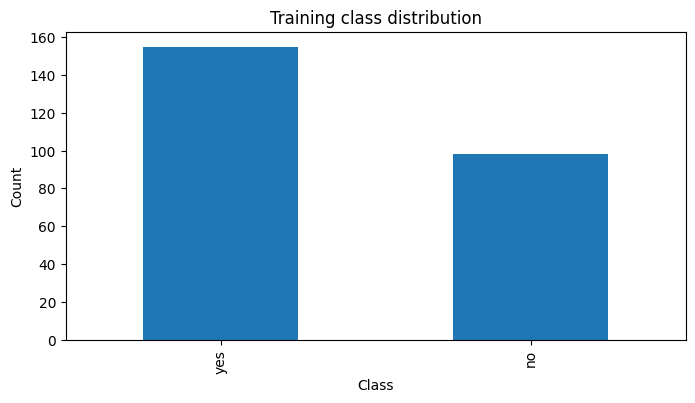

In [ ]:
plt.figure(figsize=(8,4))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Training class distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#Visualize sample images per class

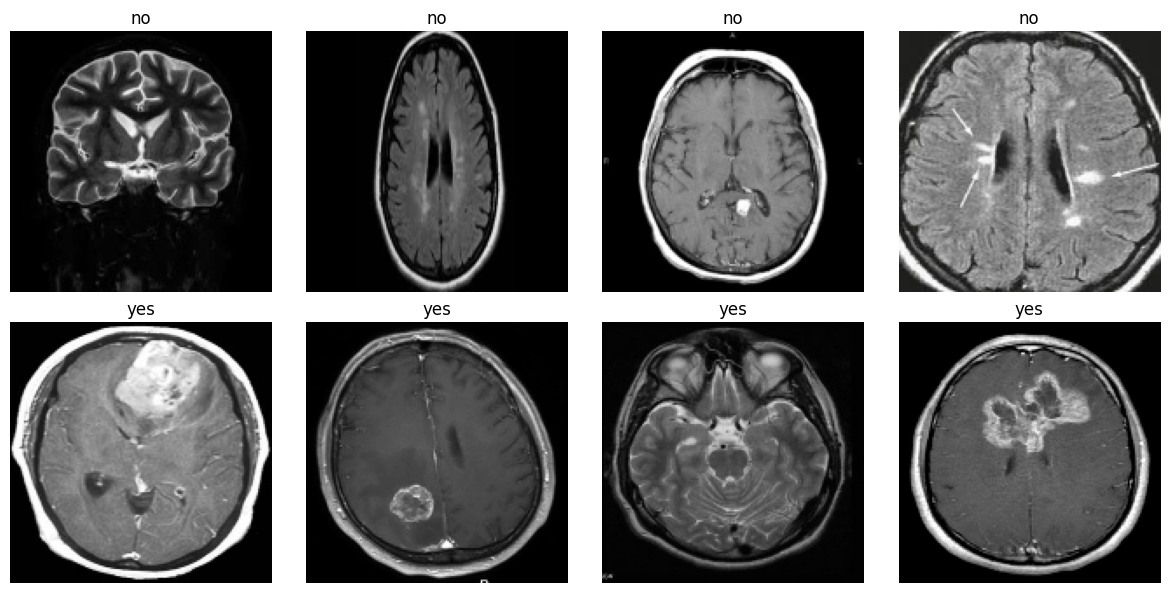

In [ ]:
import cv2
IMG_DISPLAY = 150
num_classes = len(CATEGORIES)
plt.figure(figsize=(12, 3 * num_classes))
for i, c in enumerate(CATEGORIES):
    sample_fp = train_df[train_df['label'] == c]['filepath'].values[:4]
    for j, fp in enumerate(sample_fp):
        img = cv2.imread(fp)
        if img is None:
             img = np.zeros((IMG_DISPLAY, IMG_DISPLAY, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(num_classes, 4, i*4 + j + 1)
        ax.imshow(cv2.resize(img, (IMG_DISPLAY, IMG_DISPLAY)))
        ax.set_title(c)
        ax.axis('off')
plt.tight_layout()
plt.show()

Settings: image size, batch size, epochs

In [ ]:
IMG_SIZE = (128, 128) # try 128 or 224 depending on compute
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = len(CATEGORIES)

#Data augmentation and generators

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)


validation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

Found 253 validated image filenames belonging to 2 classes.
Found 253 validated image filenames belonging to 2 classes.


#Build the CNN model

In [ ]:
def build_model(input_shape=(128,128,3), num_classes=4):
    model = Sequential()


    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))


    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))


    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))


    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(num_classes, activation='softmax'))
    return model


model = build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,484,546 (32.37 MB)

 Trainable params: 8,483,586 (32.36 MB)

 Non-trainable params: 960 (3.75 KB)

#Callbacks and training

In [ ]:
checkpoint_path = 'best_brain_tumor_model.h5'
callbacks = [
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


steps_per_epoch = max(1, len(train_df) // BATCH_SIZE)
validation_steps = max(1, len(test_df) // BATCH_SIZE)


history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5487 - loss: 1.4515
Epoch 1: val_accuracy improved from -inf to 0.60714, saving model to best_brain_tumor_model.h5


7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5564 - loss: 1.4405 - val_accuracy: 0.6071 - val_loss: 0.6537 - learning_rate: 1.0000e-04
Epoch 2/30
1/7 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8125 - loss: 0.8618

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.60714
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8125 - loss: 0.8618 - val_accuracy: 0.6027 - val_loss: 0.6538 - learning_rate: 1.0000e-04
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7212 - loss: 0.7338
Epoch 3: val_accuracy did not improve from 0.60714
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.7216 - loss: 0.7379 - val_accuracy: 0.6027 - val_loss: 0.6637 - learning_rate: 1.0000e-04
Epoch 4/30
1/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8438 - loss: 0.3754
Epoch 4: val_accuracy did not improve from 0.60714

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8438 - loss: 0.3754 - val_accuracy: 0.6027 - val_loss: 0.6630 - learning_rate: 1.0000e-04
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6812 - loss: 0.7462
Epoch 5: val_accuracy did not improve from 0.60714
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.6

#Plot training curves



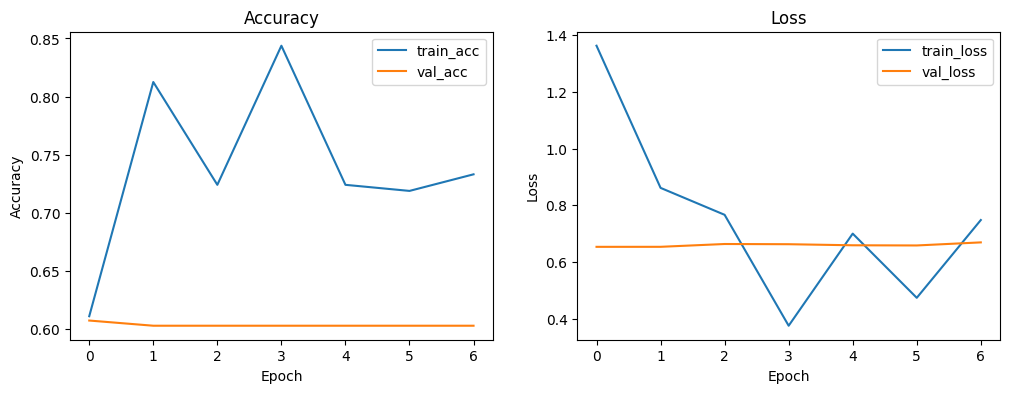

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()


#Evaluation on test set

In [ ]:
loss, acc = model.evaluate(validation_generator, steps=validation_steps)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.6168 - loss: 0.6470
Test loss: 0.6537, Test accuracy: 0.6071


#Predictions and confusion matrix
# Get ground truth and predictions for the whole test set

In [ ]:
validation_generator.reset()
preds = model.predict(validation_generator, steps=validation_steps, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step


*Better to predict on all test files manually*

In [ ]:
X_test = []
y_true = []
for fp, label in zip(test_df['filepath'].values, test_df['label'].values):
    img = cv2.imread(fp)
    if img is None:
        img = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype('float32') / 255.0
    X_test.append(img)
    y_true.append(label)


X_test = np.array(X_test)


pred_probs = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)
class_indices = train_generator.class_indices
inv_class_indices = {v:k for k,v in class_indices.items()}


pred_names = [inv_class_indices[idx] for idx in pred_labels]

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step


# Confusion matrix

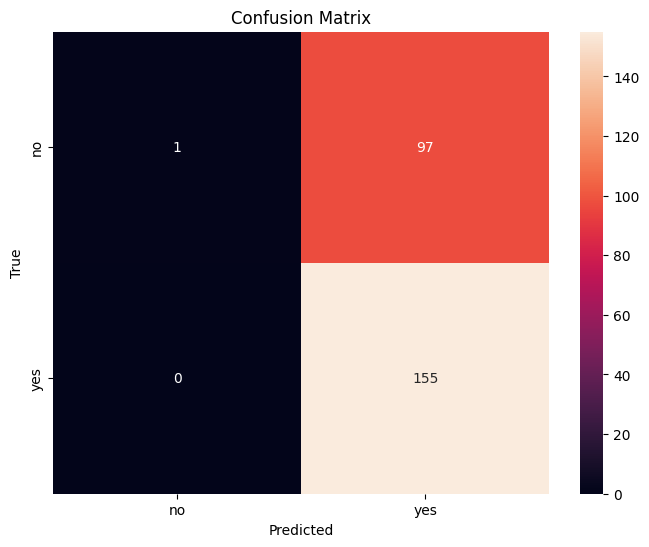

In [ ]:
cm = confusion_matrix(y_true, pred_names, labels=CATEGORIES)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Precision, recall, F1

In [ ]:
print('\nClassification Report:')
print(classification_report(y_true, pred_names, target_names=CATEGORIES))


Classification Report:
              precision    recall  f1-score   support

          no       1.00      0.01      0.02        98
         yes       0.62      1.00      0.76       155

    accuracy                           0.62       253
   macro avg       0.81      0.51      0.39       253
weighted avg       0.76      0.62      0.47       253



## Show some sample predictions with images

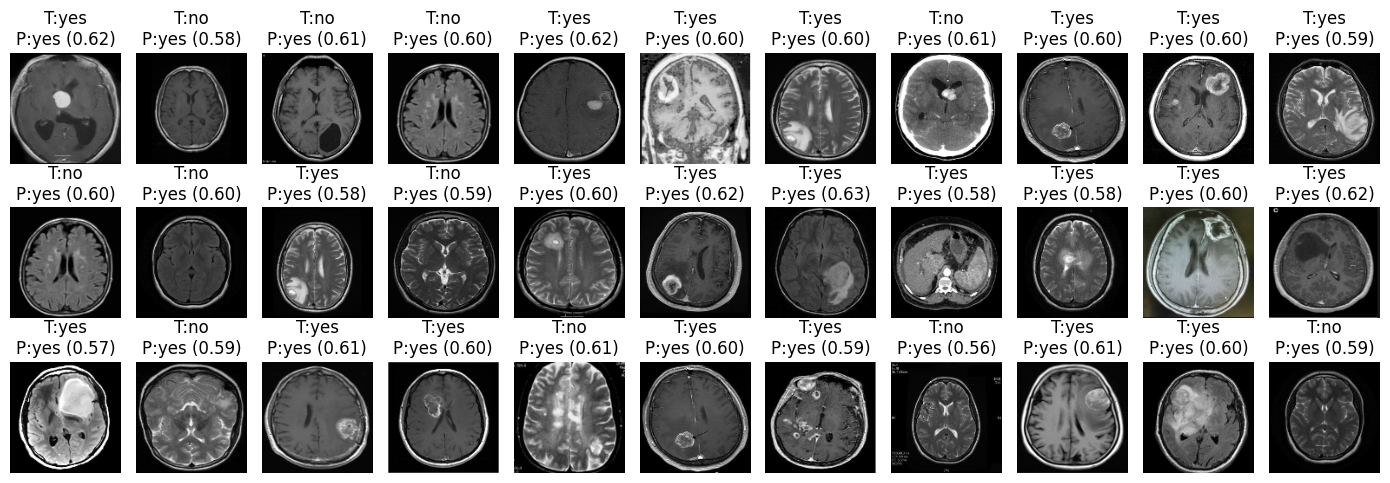

In [ ]:
n_show = 33
plt.figure(figsize=(14, 8))
indices = np.random.choice(len(X_test), size=min(n_show, len(X_test)), replace=False)
for i, idx in enumerate(indices):
    ax = plt.subplot(5, 11, i+1)
    plt.imshow(X_test[idx])
    true = y_true[idx]
    pred = pred_names[idx]
    prob = np.max(pred_probs[idx])
    ax.set_title(f'T:{true}\nP:{pred} ({prob:.2f})')
    ax.axis('off')
plt.tight_layout()
plt.show()

*Save final model and mappings*


In [ ]:
model.save('final_brain_tumor_model.keras')

In [ ]:
!apt-get install git -qq

In [ ]:
!git config --global user.name "suhani-yadav04"
!git config --global user.email "suhaniyadav1802@gmail.com "

In [ ]:
%cd /content
!git init

/content
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:
!git remote add origin https://github.com/suhani-yadav04/Brain-tumor-detection-cnn